# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [2]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


### Preprocessing

In [3]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [4]:
train['Violations'].describe()

count                                                 42261
unique                                                42164
top       45. FOOD HANDLER REQUIREMENTS MET - Comments: ...
freq                                                      3
Name: Violations, dtype: object

In [5]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [6]:
train['Fail'].value_counts(normalize=True)

0    0.74139
1    0.25861
Name: Fail, dtype: float64

In [7]:
train_violations_missing = train[train['Violations'].isnull()]
train_violations_missing['Fail'].value_counts(normalize=True)

0    0.885655
1    0.114345
Name: Fail, dtype: float64

In [8]:
train_violations_missing.head(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
11,166332,GRAND TRIPLE CROWN,GRAND TRIPLE CROWN,1878843.0,Restaurant,Risk 1 (High),3034 S HALSTED ST,CHICAGO,IL,60608.0,2011-04-04T00:00:00,Short Form Complaint,NaN,41.838812,-87.646443,"{'longitude': '-87.64644307835215', 'latitude'...",0
12,1982990,MARK TWAIN ELEMENTARY,MARK TWAIN ELEMENTARY,25661.0,School,Risk 1 (High),5134 S LOTUS,CHICAGO,IL,60638.0,2017-02-10T00:00:00,Canvass Re-Inspection,NaN,41.799052,-87.758965,"{'longitude': '-87.75896524463428', 'latitude'...",0
15,2071751,VICEROY HOTEL,VICEROY HOTEL,2535449.0,Liquor,Risk 3 (Low),1118 N STATE ST,CHICAGO,IL,60610.0,2017-08-01T00:00:00,License,NaN,41.902312,-87.628497,"{'longitude': '-87.62849738136275', 'latitude'...",0
24,1631721,VEGAN NOW INC,VEGAN NOW,2447002.0,Restaurant,Risk 2 (Medium),131 N CLINTON ST,CHICAGO,IL,60661.0,2016-02-16T00:00:00,License,NaN,41.884188,-87.641120,"{'longitude': '-87.64111966683218', 'latitude'...",0
28,2166234,BARWAQO KABOB ONE,BARWAQO KABOB ONE,2589600.0,Restaurant,Risk 1 (High),939 N ORLEANS ST,CHICAGO,IL,60610.0,2018-04-17T00:00:00,License Re-Inspection,NaN,41.900150,-87.637161,"{'longitude': '-87.63716134942399', 'latitude'...",0
29,519292,CITGO GAS,CITGO GAS,2093475.0,Grocery Store,Risk 2 (Medium),4064-4070 N CLARK ST,CHICAGO,IL,60613.0,2011-11-01T00:00:00,Complaint,NaN,41.956094,-87.663477,"{'longitude': '-87.66347696035288', 'latitude'...",0
40,1198883,RANGE,RANGE,2261809.0,Restaurant,Risk 1 (High),1119-1121 W WEBSTER AVE,CHICAGO,IL,60614.0,2013-05-24T00:00:00,License,NaN,41.921577,-87.656727,"{'longitude': '-87.65672651542604', 'latitude'...",1
41,598469,DUNKIN DONUTS,DUNKIN DONUTS,66356.0,Restaurant,Risk 2 (Medium),2356 W CERMAK RD,CHICAGO,IL,60608.0,2011-11-17T00:00:00,Canvass Re-Inspection,NaN,41.852142,-87.685518,"{'longitude': '-87.6855182624321', 'latitude':...",0
50,521901,COQUITO COCINA PUERTORRIQUENA,COQUITO COCINA PUERTORRIQUENA,2093842.0,Restaurant,Risk 1 (High),3824 N KEDZIE AVE,CHICAGO,IL,60618.0,2011-11-29T00:00:00,License,NaN,41.951051,-87.708085,"{'longitude': '-87.70808483065089', 'latitude'...",0
52,1578690,"WENDY'S PROPERTIES, LLC",WENDY'S,2405955.0,Restaurant,Risk 1 (High),3943 N HARLEM AVE,CHICAGO,IL,60634.0,2015-10-08T00:00:00,License Re-Inspection,NaN,41.952042,-87.807095,"{'longitude': '-87.80709474254513', 'latitude'...",0


In [9]:
train['training_set'] = True
test['training_set'] = False

full = pd.concat([train, test])

full.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail,training_set
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,True
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,True
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,True
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,True
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,True


In [10]:
full = full.dropna()
full.isna().sum()

Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Violations         0
Latitude           0
Longitude          0
Location           0
Fail               0
training_set       0
dtype: int64

In [11]:
full.shape

(55487, 18)

In [12]:
train = full[full['training_set'] == True]
train = train.drop('training_set', axis=1)

test = full[full['training_set'] == False]
test = test.drop('training_set', axis=1)

In [13]:
train.shape, test.shape

((41665, 17), (13822, 17))

## Modeling

In [14]:
X_train = train.drop('Fail', axis=1)
y_train = train['Fail']

In [15]:
X_train.shape, y_train.shape

((41665, 16), (41665,))

### ROC AUC for the Training Set

In [16]:
import category_encoders as ce
from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier



pipe = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    min_samples_leaf=0.005,
    oob_score=True,
    n_jobs=-1)
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', verbose=10)
#print("Cross-Validated ROC AUC scores: {}".format(cv_roc_auc_scores))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.6894738963490508, total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] ....................... , score=0.6886580251873284, total=   4.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s


[CV] ....................... , score=0.7054735468703921, total=   5.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.9s remaining:    0.0s


[CV] ....................... , score=0.7060301432022278, total=   4.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   21.8s remaining:    0.0s


[CV] ....................... , score=0.7033690406960489, total=   4.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.4s finished


array([0.6894739 , 0.68865803, 0.70547355, 0.70603014, 0.70336904])

In [17]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['DBA Name', 'AKA Name', 'Facility Type', 'Risk', 'Address', 'City', 'State', 'Inspection Date', 'Inspection Type', 'Violations', 'Location'],
        drop_invariant=False, handle_unknown='impute', impute_missing=True,
        mapping=[{'col': 'DBA Name'...mators=100, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False))])

In [18]:
test.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,114835,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'...",0
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'...",0
2,671061,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'...",0
3,1965844,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'...",1
4,1751669,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'...",1


### ROC AUC for the Test set

In [19]:
X_test = test.drop('Fail', axis=1)
y_test = test['Fail']

X_test.shape, y_test.shape

((13822, 16), (13822,))

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

pipe.fit(X_test, y_test)
y_pred_proba = pipe.named_steps['randomforestclassifier'].oob_decision_function_[:, 1]
print('ROC AUC, Out-of-Bag estimate for test set:', roc_auc_score(y_test, y_pred_proba))


ROC AUC, Out-of-Bag estimate for test set: 0.6930357992514172


In [21]:
y_pred = pipe.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.7622905635431723

### Visualization

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.named_steps['randomforestclassifier'].feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    

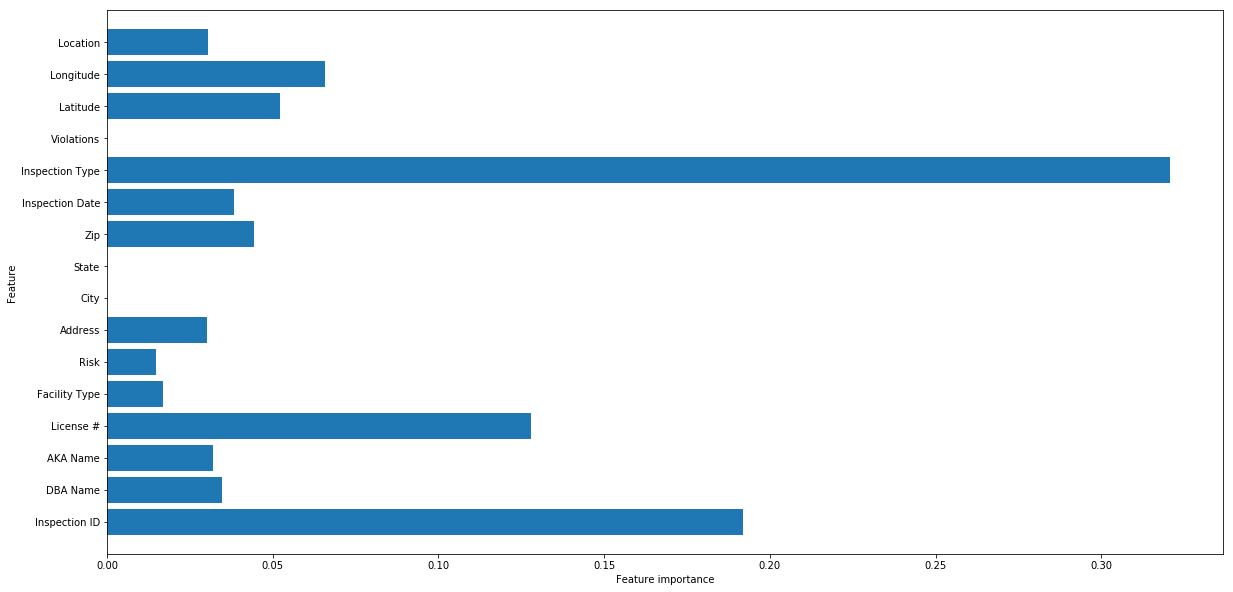

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))

plot_feature_importances(pipe)

In [24]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [25]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

### Partial Dependence Plot

In [26]:
encoder = ce.OrdinalEncoder(handle_unknown='ignore', cols=['DBA Name', 'AKA Name', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Inspection Date',
       'Inspection Type', 'Violations', 'Location'])
train_transformed = encoder.fit_transform(train)
train_transformed.head(10)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,1,1,2354911.0,1,1,1,1,1,60657.0,1,1,1,41.938007,-87.644755,1,1
1,555268,2,2,1044901.0,2,2,2,1,1,60636.0,2,2,2,41.772402,-87.683603,2,0
2,1751394,3,3,47405.0,1,1,3,1,1,60649.0,3,3,3,41.758779,-87.575054,3,0
3,1763905,4,4,6414.0,1,3,4,1,1,60632.0,4,1,4,41.812181,-87.707125,4,0
5,1725221,5,5,2245580.0,3,1,5,1,1,60614.0,5,1,5,41.932632,-87.647973,5,0
6,1981372,6,6,32318.0,1,3,6,1,1,60606.0,6,1,6,41.878531,-87.639427,6,0
8,1464616,7,7,1544937.0,1,1,7,1,1,60660.0,7,1,7,41.993973,-87.660242,7,1
9,583261,8,8,2098003.0,1,1,8,1,1,60616.0,8,4,8,41.855282,-87.631993,8,1
10,1516695,9,9,36823.0,2,1,9,1,1,60629.0,9,5,9,41.789113,-87.703580,9,0
13,635040,10,10,2089284.0,1,1,10,1,1,60626.0,10,5,10,42.008692,-87.666350,10,0


In [27]:
train_transformed.isna().sum()

Inspection ID      0
DBA Name           0
AKA Name           0
License #          0
Facility Type      0
Risk               0
Address            0
City               0
State              0
Zip                0
Inspection Date    0
Inspection Type    0
Violations         0
Latitude           0
Longitude          0
Location           0
Fail               0
dtype: int64

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

X = train_transformed.drop('Fail', axis=1)
y = train_transformed['Fail']

gb = GradientBoostingClassifier()

cross_val_score(gb, X, y, scoring='roc_auc', cv=5, n_jobs=-1)

array([0.64645162, 0.69711013, 0.70884841, 0.71001496, 0.70286667])

In [30]:
gb.fit(X, y)
pd.Series(gb.feature_importances_, X.columns)

Inspection ID      0.323480
DBA Name           0.003481
AKA Name           0.007903
License #          0.055757
Facility Type      0.026563
Risk               0.010357
Address            0.004715
City               0.000000
State              0.000000
Zip                0.030315
Inspection Date    0.004806
Inspection Type    0.458865
Violations         0.001927
Latitude           0.027659
Longitude          0.037918
Location           0.006254
dtype: float64

#### We isolate for Inspection Type because it has the highest feature importance for the Gradient Boosting model

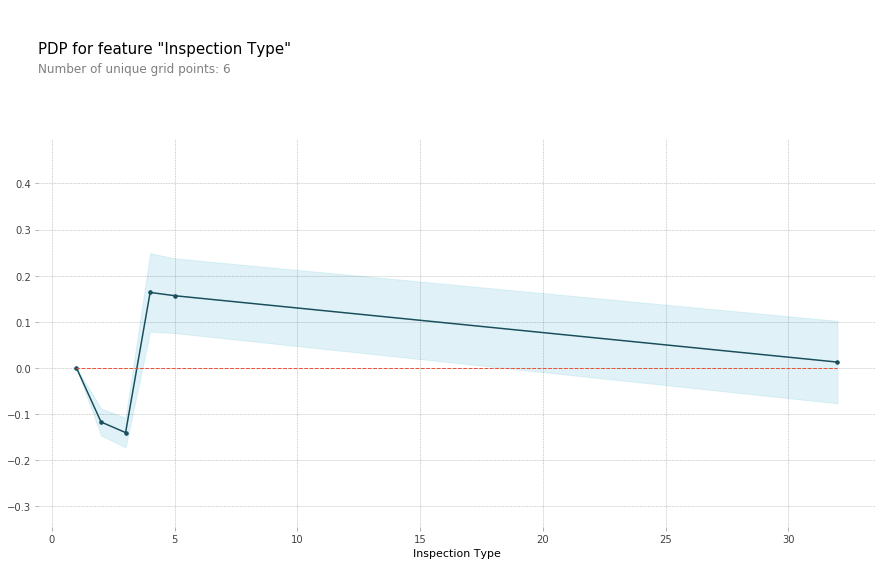

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature='Inspection Type'
pdp_isolated = pdp_isolate(model=gb, dataset=X, model_features=X.columns, feature=feature)
pdp_plot(pdp_isolated, feature);


In [32]:
train_transformed.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,1,1,2354911.0,1,1,1,1,1,60657.0,1,1,1,41.938007,-87.644755,1,1
1,555268,2,2,1044901.0,2,2,2,1,1,60636.0,2,2,2,41.772402,-87.683603,2,0
2,1751394,3,3,47405.0,1,1,3,1,1,60649.0,3,3,3,41.758779,-87.575054,3,0
3,1763905,4,4,6414.0,1,3,4,1,1,60632.0,4,1,4,41.812181,-87.707125,4,0
5,1725221,5,5,2245580.0,3,1,5,1,1,60614.0,5,1,5,41.932632,-87.647973,5,0


In [33]:
train['Inspection Type'].value_counts(normalize=True)

Canvass                                   0.549286
License                                   0.117197
Complaint                                 0.114509
Canvass Re-Inspection                     0.104284
Complaint Re-Inspection                   0.036025
Short Form Complaint                      0.035233
License Re-Inspection                     0.025945
Suspected Food Poisoning                  0.004800
Tag Removal                               0.002712
Consultation                              0.002472
License-Task Force                        0.002328
Recent Inspection                         0.001056
Complaint-Fire                            0.001008
Suspected Food Poisoning Re-inspection    0.000912
Task Force Liquor 1475                    0.000768
Short Form Fire-Complaint                 0.000528
Special Events (Festivals)                0.000312
Complaint-Fire Re-inspection              0.000216
Package Liquor 1474                       0.000096
TAVERN 1470                    

In [34]:
train_transformed['Inspection Type'].value_counts(normalize=True)

1     0.549286
4     0.117197
5     0.114509
3     0.104284
2     0.036025
7     0.035233
6     0.025945
15    0.004800
10    0.002712
9     0.002472
14    0.002328
16    0.001056
11    0.001008
17    0.000912
12    0.000768
18    0.000528
8     0.000312
13    0.000216
24    0.000096
31    0.000024
30    0.000024
19    0.000024
20    0.000024
21    0.000024
22    0.000024
23    0.000024
25    0.000024
26    0.000024
27    0.000024
28    0.000024
29    0.000024
32    0.000024
Name: Inspection Type, dtype: float64

In [37]:
inspection_type_license = train[train['Inspection Type'] == 'License']

inspection_type_license['Fail'].value_counts(normalize=True)

0    0.515871
1    0.484129
Name: Fail, dtype: float64

In [39]:
inspection_type_complaint = train[train['Inspection Type'] == 'Complaint']

inspection_type_complaint['Fail'].value_counts(normalize=True)

0    0.5655
1    0.4345
Name: Fail, dtype: float64

In [40]:
train['Fail'].value_counts(normalize=True)

0    0.70954
1    0.29046
Name: Fail, dtype: float64

### The Partial Dependence Plot shows 'Inspection Type' of License and Complaint shows the highest values.  And sure enough when we examine the Fail rates for those Inspection Types above they're much higher than that for the whole training set.

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._